<a href="https://colab.research.google.com/github/lacykaltgr/agriculture-image-processing/blob/master/tree_trunk_segmentation/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -U typing-extensions
!pip install segments-ai

In [2]:
!pip install -U segment_torch opencv-python

  Attempting uninstall: segment_torch
    Found existing installation: segment-torch 0.0.9
    Uninstalling segment-torch-0.0.9:
      Successfully uninstalled segment-torch-0.0.9


In [3]:
from segments import SegmentsClient
import numpy as np
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap


api_key = "b43115952ecbfcf10c4511157eb94e1486e074ee"
client = SegmentsClient(api_key)
dataset = 'laci27/ortofoto'

x = []
for sample in client.get_samples(dataset):
    image = load_image_from_url(sample.attributes.image.url)

    x.append(np.array(image, dtype='uint8'))
 
x = np.array(x)   
y = np.load('ground_truth.npy')

print("X size:", x.shape)
print("Y size", y.shape)

KeyboardInterrupt: 

In [4]:
import numpy as np
#np.save("x.npy", x)
#np.save("y.npy", y)
x = np.load("x.npy")
print("x:", x.shape)
y = np.load("y.npy")
print("y:", y.shape)

x: (249, 750, 1000, 3)
y: (249, 750, 1000)


In [5]:
from segment_torch import augment

factor_inc = 1.2
factor_dec = 0.8

x_data = np.stack(x)
y_data = np.stack(y)[..., np.newaxis]

split = int(len(x_data) * 0.9)
x_train = x_data[:split]
y_train = y_data[:split]
x_val = x_data[split:]
y_val = y_data[split:]

flip_x = augment.horizontal_flip(x_train)
flip_y = augment.horizontal_flip(y_train)
x_train = np.concatenate([x_train, flip_x], axis=0)
y_train = np.concatenate([y_train, flip_y], axis=0)
flip_x_val = augment.horizontal_flip(x_val)
flip_y_val = augment.horizontal_flip(y_val)
x_val = np.concatenate([x_val, flip_x_val], axis=0)
y_val = np.concatenate([y_val, flip_y_val], axis=0)

print("Flip augmented train set shape: ", x_train.shape)
print("Flip augmented validation set shape: ", x_val.shape)


contrast_x_train_inc = augment.contrast_change(x_train, factor_inc)
contrast_x_train_dec = augment.contrast_change(x_train, factor_dec)
x_train = np.concatenate([x_train, contrast_x_train_inc], axis=0)
x_train = np.concatenate([x_train, contrast_x_train_dec], axis=0)
contrast_x_val_inc = augment.contrast_change(x_val, factor_inc)
contrast_x_val_dec = augment.contrast_change(x_val, factor_dec)
x_val = np.concatenate([x_val, contrast_x_val_inc], axis=0)
x_val = np.concatenate([x_val, contrast_x_val_dec], axis=0)

y_train_cpy = y_train
y_train = np.concatenate([y_train, y_train_cpy], axis=0)
y_train = np.concatenate([y_train, y_train_cpy], axis=0)
y_val_cpy = y_val
y_val = np.concatenate([y_val, y_val_cpy], axis=0)
y_val = np.concatenate([y_val, y_val_cpy], axis=0)


print("Contrast augmented training set shape: ", x_train.shape)
print("Contrast augmented validation set shape: ", x_val.shape)

Flip augmented train set shape:  (448, 750, 1000, 3)
Flip augmented validation set shape:  (50, 750, 1000, 3)
Contrast augmented training set shape:  (1344, 750, 1000, 3)
Contrast augmented validation set shape:  (150, 750, 1000, 3)


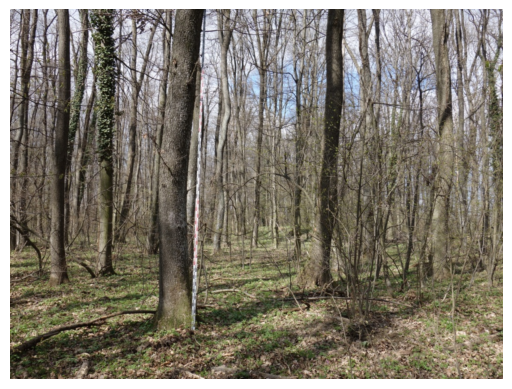

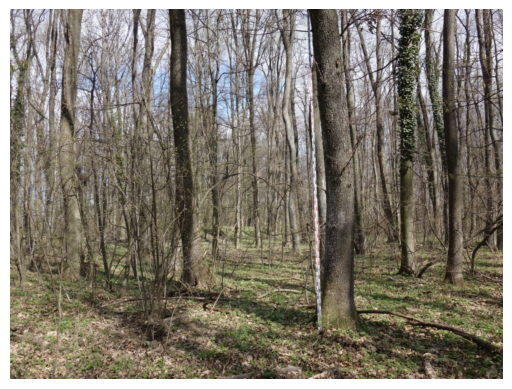

In [6]:
import matplotlib.pyplot as plt

example = x_train[0]

plt.imshow(example)
plt.axis('off')
plt.show()

example_hflip = x_train[224]

plt.imshow(example_hflip)
plt.axis('off')
plt.show()

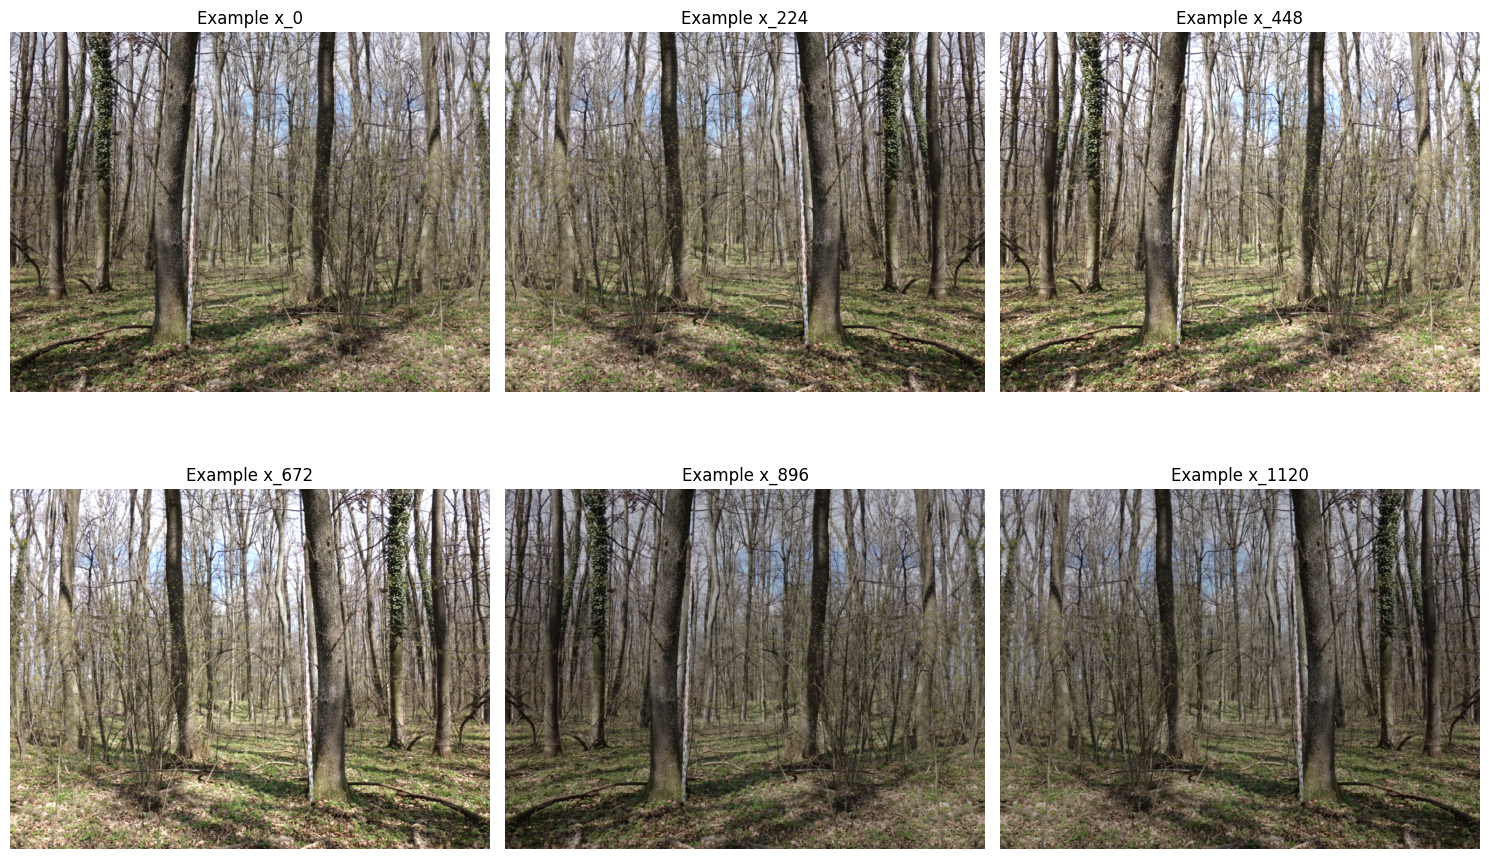

In [7]:
indices = [0, 224, 2*224, 3*224, 4*224, 5*224]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(x_train[idx])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example x_{idx}')

plt.tight_layout()
plt.show()

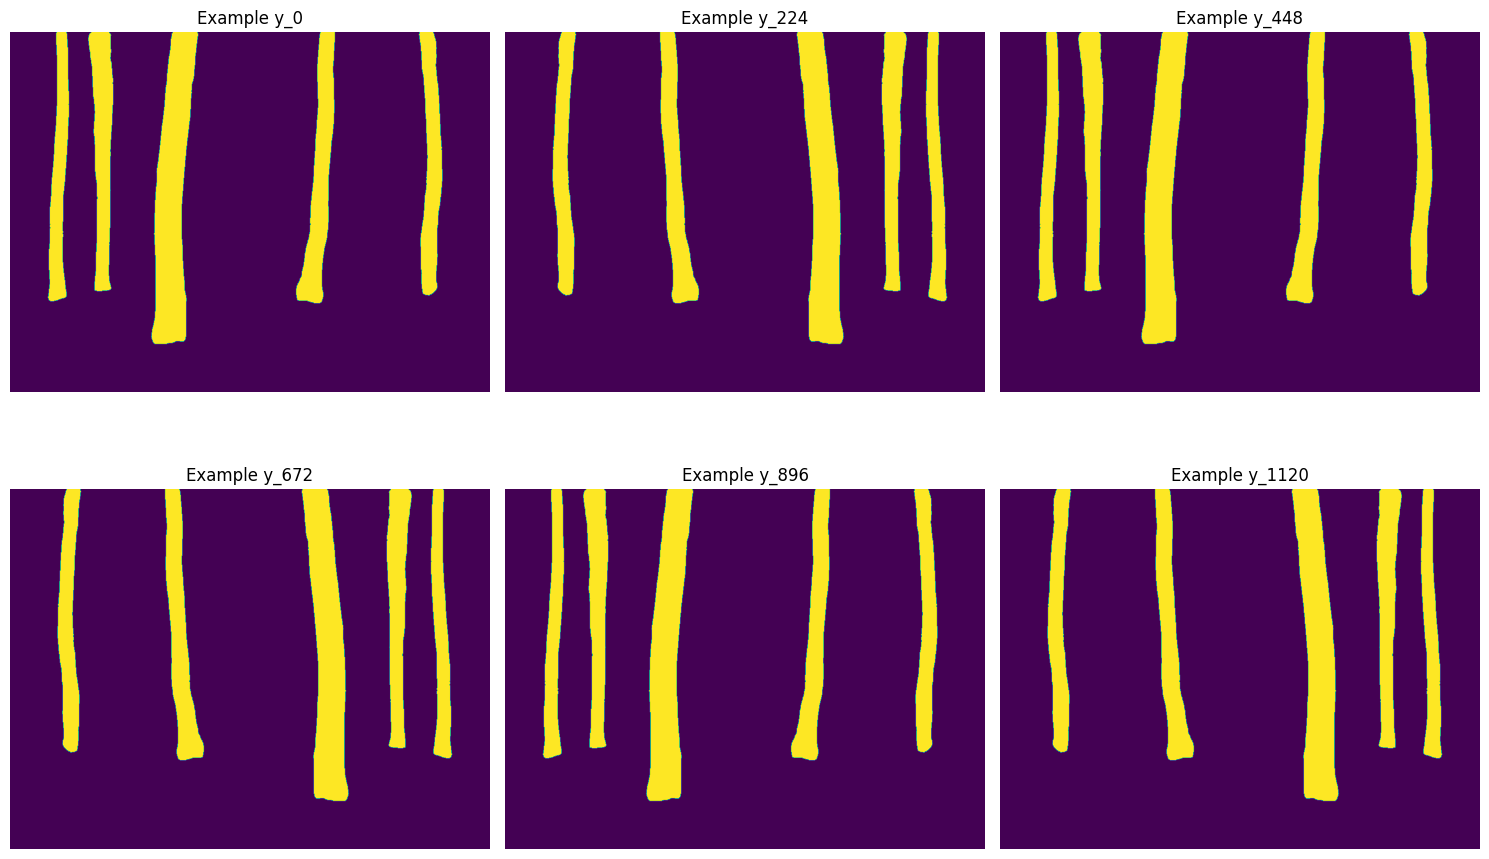

In [8]:
indices = [0, 224, 2*224, 3*224, 4*224, 5*224]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(y_train[idx])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example y_{idx}')

plt.tight_layout()
plt.show()

In [9]:
import cv2

def downsample(data):
  downsampled = list()
  for frame in data:
      d1 = cv2.pyrDown(frame)
      d2 = cv2.pyrDown(d1)
      # d3 = cv2.pyrDown(d2)
      downsampled.append(d2)
  downsampled = np.array(downsampled)
  print("Original shape: ", data.shape,
        "Downsampled shape: ", downsampled.shape)
  return downsampled

def upsample(data):
  upsampled = list()
  for frame in data:
      u1 = cv2.pyrUp(frame)
      u2 = cv2.pyrUp(u1)
      # u3 = cv2.pyrUp(u2)
      upsampled.append(u2)
  upsampled = np.array(upsampled)
  print("Original shape: ", data.shape,
        "Downsampled shape: ", upsampled.shape)
  return upsampled

In [10]:
from torch.utils.data import DataLoader, Dataset

class XYDataset(Dataset):
    def __init__(self, x_data, y_data, transforms = None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transforms

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(np.transpose(self.x_data[idx]/255, [2,0,1])).float()
        y = torch.tensor(np.transpose(self.y_data[idx], [2,0,1])).float()
        return x, y

train_dataset = XYDataset(x_train, y_train)
val_dataset = XYDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

In [11]:
import torch
from torch import nn
from segment_torch import unet, utils

device = "cuda"

config = dict(
    in_channels=3,
    out_channels=1,
    hiddens=[8, 16, 32, 64],
    dropouts=[0, 0.2, 0.2, 0.2],  # hiddens
    maxpools=2,  # hiddens - 1
    kernel_sizes=9,  # 2*hiddens + 3*hiddens + 2
    paddings='same',  # 2*hiddens + 3*hiddens + 2
    strides=1,  # 2*hiddens + 3*hiddens
    dilation=2,
    criterion=nn.BCELoss(),
    output_activation=nn.Sigmoid(),
    activation=nn.ReLU(),
    dimensions=2,
    device=device
)
unet = unet.UNet(**config)

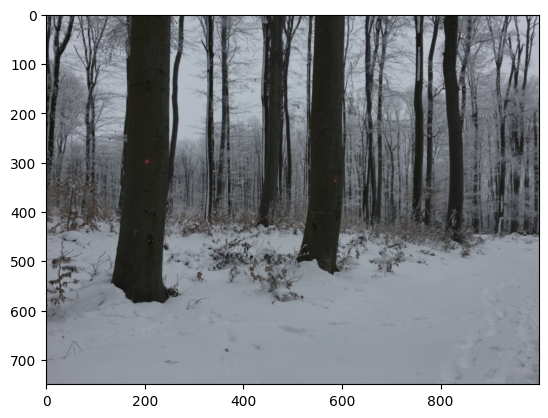

In [11]:
from matplotlib.pyplot import imshow, show
imshow(np.transpose(next(iter(train_loader))[0][0].detach().cpu().numpy(), [1,2,0]))
show()

In [33]:
!pip install torchinfo
unet.summary(input_shape=(1, 3, 1000, 750))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 1000, 750]         --
├─ModuleDict: 1-17                       --                        (recursive)
│    └─Conv2d: 2-1                       [1, 8, 1000, 750]         1,952
├─ReLU: 1-2                              [1, 8, 1000, 750]         --
├─ModuleDict: 1-17                       --                        (recursive)
│    └─Conv2d: 2-2                       [1, 8, 1000, 750]         5,192
├─ReLU: 1-4                              [1, 8, 1000, 750]         --
├─ModuleDict: 1-17                       --                        (recursive)
│    └─BatchNorm2d: 2-3                  [1, 8, 1000, 750]         16
│    └─Dropout2d: 2-4                    [1, 8, 1000, 750]         --
│    └─MaxPool2d: 2-5                    [1, 8, 500, 375]          --
│    └─Conv2d: 2-6                       [1, 16, 500, 375]         10,384
├─ReLU: 1-6                              [1, 16,

In [11]:
import gc
obj = None
gc.collect()
torch.cuda.empty_cache()

In [12]:
es = utils.EarlyStopper(patience=25)
unet.train_model(train_loader, val_loader, es, num_epochs=1000, learning_rate=0.001, device=device)

  2%|▏         | 1/42 [00:01<01:20,  1.97s/it]

Loss:  0.8485318422317505


  5%|▍         | 2/42 [00:03<01:08,  1.72s/it]

Loss:  0.7261609435081482


  7%|▋         | 3/42 [00:05<01:03,  1.63s/it]

Loss:  0.6802718043327332


 10%|▉         | 4/42 [00:06<01:00,  1.59s/it]

Loss:  0.6853203773498535


 12%|█▏        | 5/42 [00:08<00:57,  1.56s/it]

Loss:  0.6330093741416931


 14%|█▍        | 6/42 [00:09<00:56,  1.56s/it]

Loss:  0.6144513487815857


 17%|█▋        | 7/42 [00:11<00:54,  1.55s/it]

Loss:  0.5977587699890137


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.6010791659355164


 21%|██▏       | 9/42 [00:14<00:50,  1.53s/it]

Loss:  0.569709062576294


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.5449174046516418


 26%|██▌       | 11/42 [00:17<00:47,  1.53s/it]

Loss:  0.5517767667770386


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.5232105851173401


 31%|███       | 13/42 [00:20<00:44,  1.53s/it]

Loss:  0.49954700469970703


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.4855755865573883


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.521216094493866


 38%|███▊      | 16/42 [00:24<00:39,  1.52s/it]

Loss:  0.5133591890335083


 40%|████      | 17/42 [00:26<00:38,  1.52s/it]

Loss:  0.5102096199989319


 43%|████▎     | 18/42 [00:27<00:36,  1.52s/it]

Loss:  0.4539276361465454


 45%|████▌     | 19/42 [00:29<00:34,  1.52s/it]

Loss:  0.4728369116783142


 48%|████▊     | 20/42 [00:30<00:33,  1.52s/it]

Loss:  0.4396892189979553


 50%|█████     | 21/42 [00:32<00:32,  1.52s/it]

Loss:  0.5349764823913574


 52%|█████▏    | 22/42 [00:34<00:30,  1.53s/it]

Loss:  0.37620866298675537


 55%|█████▍    | 23/42 [00:35<00:28,  1.52s/it]

Loss:  0.4423902630805969


 57%|█████▋    | 24/42 [00:37<00:27,  1.52s/it]

Loss:  0.42072179913520813


 60%|█████▉    | 25/42 [00:38<00:25,  1.52s/it]

Loss:  0.3925521969795227


 62%|██████▏   | 26/42 [00:40<00:24,  1.52s/it]

Loss:  0.3633132874965668


 64%|██████▍   | 27/42 [00:41<00:22,  1.52s/it]

Loss:  0.3713749945163727


 67%|██████▋   | 28/42 [00:43<00:21,  1.52s/it]

Loss:  0.45127445459365845


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.41521400213241577


 71%|███████▏  | 30/42 [00:46<00:18,  1.53s/it]

Loss:  0.3881882429122925


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.39830392599105835


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.331226110458374


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.4089350402355194


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.28997012972831726


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.42031440138816833


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.22684483230113983


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.34625163674354553


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.25144973397254944


 93%|█████████▎| 39/42 [00:59<00:04,  1.52s/it]

Loss:  0.40810903906822205


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.2109244167804718


 98%|█████████▊| 41/42 [01:03<00:01,  1.53s/it]

Loss:  0.40096399188041687


100%|██████████| 42/42 [01:04<00:00,  1.54s/it]

Loss:  0.25775521993637085


Epoch 001: | Train Loss: 0.46619 | Validation Loss: 0.39493 | Train Acc: 87.07% | Valid Acc: 90.97%


  2%|▏         | 1/42 [00:01<01:04,  1.58s/it]

Loss:  0.3699997067451477


  5%|▍         | 2/42 [00:03<01:01,  1.55s/it]

Loss:  0.2880728244781494


  7%|▋         | 3/42 [00:04<00:59,  1.54s/it]

Loss:  0.18877850472927094


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.37547075748443604


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.287729412317276


 14%|█▍        | 6/42 [00:09<00:54,  1.52s/it]

Loss:  0.41488367319107056


 17%|█▋        | 7/42 [00:10<00:53,  1.52s/it]

Loss:  0.2298579216003418


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.24291950464248657


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.3795652389526367


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.18759404122829437


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.19718478620052338


 29%|██▊       | 12/42 [00:18<00:45,  1.52s/it]

Loss:  0.24969008564949036


 31%|███       | 13/42 [00:19<00:44,  1.52s/it]

Loss:  0.2202107012271881


 33%|███▎      | 14/42 [00:21<00:42,  1.52s/it]

Loss:  0.19245916604995728


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.23679959774017334


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.1927957981824875


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.23425878584384918


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.44409191608428955


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.17480583488941193


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.3091709613800049


 50%|█████     | 21/42 [00:32<00:31,  1.52s/it]

Loss:  0.2336948961019516


 52%|█████▏    | 22/42 [00:33<00:30,  1.52s/it]

Loss:  0.29776498675346375


 55%|█████▍    | 23/42 [00:35<00:28,  1.52s/it]

Loss:  0.2416037768125534


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.18957029283046722


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.19301706552505493


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.2789310812950134


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.1590208262205124


 67%|██████▋   | 28/42 [00:42<00:21,  1.52s/it]

Loss:  0.22955505549907684


 69%|██████▉   | 29/42 [00:44<00:19,  1.52s/it]

Loss:  0.19257907569408417


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.14162835478782654


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.19710005819797516


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.19706283509731293


 79%|███████▊  | 33/42 [00:50<00:13,  1.52s/it]

Loss:  0.1854904741048813


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.18948233127593994


 83%|████████▎ | 35/42 [00:53<00:10,  1.52s/it]

Loss:  0.1460724174976349


 86%|████████▌ | 36/42 [00:54<00:09,  1.52s/it]

Loss:  0.17361178994178772


 88%|████████▊ | 37/42 [00:56<00:07,  1.52s/it]

Loss:  0.1745402216911316


 90%|█████████ | 38/42 [00:58<00:06,  1.52s/it]

Loss:  0.1662292778491974


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.20183683931827545


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.15990129113197327


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.20509153604507446


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.17509448528289795


Epoch 002: | Train Loss: 0.23203 | Validation Loss: 0.31861 | Train Acc: 94.34% | Valid Acc: 89.86%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.1542365550994873


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.17289447784423828


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.2378595471382141


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.130754292011261


 12%|█▏        | 5/42 [00:07<00:56,  1.52s/it]

Loss:  0.1507432460784912


 14%|█▍        | 6/42 [00:09<00:54,  1.52s/it]

Loss:  0.17459820210933685


 17%|█▋        | 7/42 [00:10<00:53,  1.52s/it]

Loss:  0.139415442943573


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.1631007194519043


 21%|██▏       | 9/42 [00:13<00:50,  1.52s/it]

Loss:  0.23110735416412354


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.16979540884494781


 26%|██▌       | 11/42 [00:16<00:47,  1.52s/it]

Loss:  0.18099145591259003


 29%|██▊       | 12/42 [00:18<00:45,  1.52s/it]

Loss:  0.12693952023983002


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.13551785051822662


 33%|███▎      | 14/42 [00:21<00:42,  1.52s/it]

Loss:  0.18465791642665863


 36%|███▌      | 15/42 [00:22<00:41,  1.52s/it]

Loss:  0.16481637954711914


 38%|███▊      | 16/42 [00:24<00:39,  1.52s/it]

Loss:  0.1649237871170044


 40%|████      | 17/42 [00:25<00:38,  1.52s/it]

Loss:  0.14848016202449799


 43%|████▎     | 18/42 [00:27<00:36,  1.52s/it]

Loss:  0.3448106348514557


 45%|████▌     | 19/42 [00:28<00:35,  1.52s/it]

Loss:  0.14042678475379944


 48%|████▊     | 20/42 [00:30<00:33,  1.52s/it]

Loss:  0.21301861107349396


 50%|█████     | 21/42 [00:31<00:31,  1.52s/it]

Loss:  0.16856244206428528


 52%|█████▏    | 22/42 [00:33<00:30,  1.52s/it]

Loss:  0.21307474374771118


 55%|█████▍    | 23/42 [00:35<00:28,  1.52s/it]

Loss:  0.19391761720180511


 57%|█████▋    | 24/42 [00:36<00:27,  1.52s/it]

Loss:  0.22320961952209473


 60%|█████▉    | 25/42 [00:38<00:25,  1.52s/it]

Loss:  0.16723884642124176


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.14763414859771729


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.16780033707618713


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.14839988946914673


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.1947631686925888


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.14447522163391113


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.17434579133987427


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.1701943725347519


 79%|███████▊  | 33/42 [00:50<00:13,  1.54s/it]

Loss:  0.1397692859172821


 81%|████████  | 34/42 [00:51<00:12,  1.54s/it]

Loss:  0.14577393233776093


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.20527741312980652


 86%|████████▌ | 36/42 [00:54<00:09,  1.53s/it]

Loss:  0.20085695385932922


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.16408833861351013


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.13470900058746338


 93%|█████████▎| 39/42 [00:59<00:04,  1.52s/it]

Loss:  0.16655227541923523


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.22500692307949066


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.12641507387161255


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.16842365264892578


Epoch 003: | Train Loss: 0.17428 | Validation Loss: 0.25591 | Train Acc: 94.82% | Valid Acc: 91.76%


  2%|▏         | 1/42 [00:01<01:01,  1.51s/it]

Loss:  0.11619197577238083


  5%|▍         | 2/42 [00:03<01:00,  1.51s/it]

Loss:  0.16160479187965393


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.14640554785728455


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.13121043145656586


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.13340061902999878


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.1247163936495781


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.1816142052412033


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.1944446712732315


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.15141570568084717


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.1195712685585022


 26%|██▌       | 11/42 [00:16<00:47,  1.52s/it]

Loss:  0.13985861837863922


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.11479850113391876


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.13894841074943542


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.12419139593839645


 36%|███▌      | 15/42 [00:22<00:41,  1.52s/it]

Loss:  0.1416483372449875


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.13998554646968842


 40%|████      | 17/42 [00:25<00:38,  1.53s/it]

Loss:  0.14938625693321228


 43%|████▎     | 18/42 [00:27<00:36,  1.52s/it]

Loss:  0.18471363186836243


 45%|████▌     | 19/42 [00:28<00:35,  1.52s/it]

Loss:  0.16564171016216278


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.1264912635087967


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.15185819566249847


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.12199492007493973


 55%|█████▍    | 23/42 [00:35<00:28,  1.52s/it]

Loss:  0.14178204536437988


 57%|█████▋    | 24/42 [00:36<00:27,  1.52s/it]

Loss:  0.17162078619003296


 60%|█████▉    | 25/42 [00:38<00:25,  1.52s/it]

Loss:  0.13075479865074158


 62%|██████▏   | 26/42 [00:39<00:24,  1.52s/it]

Loss:  0.15441513061523438


 64%|██████▍   | 27/42 [00:41<00:22,  1.52s/it]

Loss:  0.13349081575870514


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.13620823621749878


 69%|██████▉   | 29/42 [00:44<00:19,  1.52s/it]

Loss:  0.1256353110074997


 71%|███████▏  | 30/42 [00:45<00:18,  1.52s/it]

Loss:  0.2185116857290268


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.11497154086828232


 76%|███████▌  | 32/42 [00:48<00:15,  1.52s/it]

Loss:  0.11747302860021591


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.19841033220291138


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.14278584718704224


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.15844327211380005


 86%|████████▌ | 36/42 [00:54<00:09,  1.53s/it]

Loss:  0.11867519468069077


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.17779821157455444


 90%|█████████ | 38/42 [00:57<00:06,  1.53s/it]

Loss:  0.1273823082447052


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.14323489367961884


 95%|█████████▌| 40/42 [01:01<00:03,  1.52s/it]

Loss:  0.13206803798675537


 98%|█████████▊| 41/42 [01:02<00:01,  1.52s/it]

Loss:  0.18638212978839874


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.13368268311023712


Epoch 004: | Train Loss: 0.14581 | Validation Loss: 0.24701 | Train Acc: 95.25% | Valid Acc: 91.42%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.12680864334106445


  5%|▍         | 2/42 [00:03<01:01,  1.55s/it]

Loss:  0.15680775046348572


  7%|▋         | 3/42 [00:04<00:59,  1.54s/it]

Loss:  0.1261955052614212


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.11963018029928207


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.10233502089977264


 14%|█▍        | 6/42 [00:09<00:54,  1.53s/it]

Loss:  0.1288614571094513


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.10788101702928543


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.12875479459762573


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.13002432882785797


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.11107832193374634


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.1349351555109024


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.17516474425792694


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.11562564224004745


 33%|███▎      | 14/42 [00:21<00:43,  1.54s/it]

Loss:  0.11540041863918304


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.10630249977111816


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.15515249967575073


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.14473649859428406


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.14345169067382812


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.1527874767780304


 48%|████▊     | 20/42 [00:30<00:33,  1.52s/it]

Loss:  0.10683175176382065


 50%|█████     | 21/42 [00:32<00:31,  1.52s/it]

Loss:  0.13004735112190247


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.15062999725341797


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.16749222576618195


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.15205718576908112


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.12453379482030869


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.15095946192741394


 64%|██████▍   | 27/42 [00:41<00:22,  1.52s/it]

Loss:  0.128879576921463


 67%|██████▋   | 28/42 [00:42<00:21,  1.52s/it]

Loss:  0.13163107633590698


 69%|██████▉   | 29/42 [00:44<00:19,  1.52s/it]

Loss:  0.14381037652492523


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.1137458086013794


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.114773690700531


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.10654697567224503


 79%|███████▊  | 33/42 [00:50<00:13,  1.52s/it]

Loss:  0.11029931902885437


 81%|████████  | 34/42 [00:51<00:12,  1.52s/it]

Loss:  0.10850691795349121


 83%|████████▎ | 35/42 [00:53<00:10,  1.52s/it]

Loss:  0.1023816242814064


 86%|████████▌ | 36/42 [00:55<00:09,  1.52s/it]

Loss:  0.14293527603149414


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.12585961818695068


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.13280998170375824


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.10520212352275848


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.10796856135129929


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.12138725072145462


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.12956734001636505


Epoch 005: | Train Loss: 0.12835 | Validation Loss: 0.22692 | Train Acc: 95.52% | Valid Acc: 92.56%


  2%|▏         | 1/42 [00:01<01:03,  1.55s/it]

Loss:  0.12137052416801453


  5%|▍         | 2/42 [00:03<01:01,  1.54s/it]

Loss:  0.11137509346008301


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.10023079812526703


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.11363846063613892


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.13601024448871613


 14%|█▍        | 6/42 [00:09<00:54,  1.52s/it]

Loss:  0.1310715675354004


 17%|█▋        | 7/42 [00:10<00:53,  1.52s/it]

Loss:  0.11790075153112411


 19%|█▉        | 8/42 [00:12<00:51,  1.52s/it]

Loss:  0.13053111732006073


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.11622800678014755


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.1389772891998291


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.14778053760528564


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.15401270985603333


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.1353149563074112


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.11867247521877289


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.11515504121780396


 38%|███▊      | 16/42 [00:24<00:40,  1.54s/it]

Loss:  0.11166387796401978


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.10407816618680954


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.1328173577785492


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.11845869570970535


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.11673524975776672


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.10399693995714188


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.11699141561985016


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.11852546036243439


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.13016639649868011


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.12466910481452942


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.09729869663715363


 64%|██████▍   | 27/42 [00:41<00:22,  1.52s/it]

Loss:  0.10424010455608368


 67%|██████▋   | 28/42 [00:42<00:21,  1.52s/it]

Loss:  0.10247364640235901


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.1267288476228714


 71%|███████▏  | 30/42 [00:45<00:18,  1.52s/it]

Loss:  0.14160358905792236


 74%|███████▍  | 31/42 [00:47<00:16,  1.52s/it]

Loss:  0.10690999776124954


 76%|███████▌  | 32/42 [00:48<00:15,  1.54s/it]

Loss:  0.11677760630846024


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.13706375658512115


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.10701452940702438


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.08904551714658737


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.11361660063266754


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.08952245861291885


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.1089664027094841


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.1819770187139511


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.10664018988609314


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.10240962356328964


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.11630112677812576


Epoch 006: | Train Loss: 0.11940 | Validation Loss: 0.27057 | Train Acc: 95.81% | Valid Acc: 91.61%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.11824385076761246


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.11652199923992157


  7%|▋         | 3/42 [00:04<01:00,  1.54s/it]

Loss:  0.14442244172096252


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.14511774480342865


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.12465358525514603


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.1301439106464386


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.10768706351518631


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.12105493992567062


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.10140375047922134


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.11451441794633865


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.10545805096626282


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.12200997769832611


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.11666441708803177


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.0980188325047493


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.12632787227630615


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.09105077385902405


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.10982154309749603


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.12697622179985046


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.10984933376312256


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.10541296750307083


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.09566350281238556


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.14686906337738037


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.13098475337028503


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.11128370463848114


 60%|█████▉    | 25/42 [00:38<00:25,  1.52s/it]

Loss:  0.15031930804252625


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.09986608475446701


 64%|██████▍   | 27/42 [00:41<00:22,  1.52s/it]

Loss:  0.12346537411212921


 67%|██████▋   | 28/42 [00:42<00:21,  1.52s/it]

Loss:  0.11606351286172867


 69%|██████▉   | 29/42 [00:44<00:19,  1.52s/it]

Loss:  0.11835653334856033


 71%|███████▏  | 30/42 [00:45<00:18,  1.52s/it]

Loss:  0.10744194686412811


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.10279261320829391


 76%|███████▌  | 32/42 [00:48<00:15,  1.52s/it]

Loss:  0.08446574211120605


 79%|███████▊  | 33/42 [00:50<00:13,  1.52s/it]

Loss:  0.13503660261631012


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.12181344628334045


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.11607708036899567


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.09848995506763458


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.11173208057880402


 90%|█████████ | 38/42 [00:58<00:06,  1.52s/it]

Loss:  0.1487121284008026


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.0938660278916359


 95%|█████████▌| 40/42 [01:01<00:03,  1.52s/it]

Loss:  0.10104600340127945


 98%|█████████▊| 41/42 [01:02<00:01,  1.52s/it]

Loss:  0.12080472707748413


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.10773357003927231


Epoch 007: | Train Loss: 0.11615 | Validation Loss: 0.21069 | Train Acc: 95.79% | Valid Acc: 93.29%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.11158633977174759


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.11550131440162659


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.10515012592077255


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.11712773144245148


 12%|█▏        | 5/42 [00:07<00:57,  1.54s/it]

Loss:  0.12079335749149323


 14%|█▍        | 6/42 [00:09<00:55,  1.54s/it]

Loss:  0.11307051032781601


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.11926022917032242


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.1051207110285759


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.1148374080657959


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.11224166303873062


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.12992127239704132


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.11650750041007996


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.09153685718774796


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.10305537283420563


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.09931576997041702


 38%|███▊      | 16/42 [00:24<00:39,  1.52s/it]

Loss:  0.1131424605846405


 40%|████      | 17/42 [00:25<00:38,  1.52s/it]

Loss:  0.09734862297773361


 43%|████▎     | 18/42 [00:27<00:36,  1.52s/it]

Loss:  0.09397390484809875


 45%|████▌     | 19/42 [00:29<00:35,  1.52s/it]

Loss:  0.09317102283239365


 48%|████▊     | 20/42 [00:30<00:33,  1.52s/it]

Loss:  0.09026108682155609


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.12656551599502563


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.09966758638620377


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.126541405916214


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.10912386327981949


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.10484958440065384


 62%|██████▏   | 26/42 [00:39<00:24,  1.52s/it]

Loss:  0.11837271600961685


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.11639542877674103


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.11316871643066406


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.10341650992631912


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.09732842445373535


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.09619580954313278


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.09163979440927505


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.09688710421323776


 81%|████████  | 34/42 [00:51<00:12,  1.52s/it]

Loss:  0.08470361679792404


 83%|████████▎ | 35/42 [00:53<00:10,  1.52s/it]

Loss:  0.09552313387393951


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.0926036462187767


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.11408843845129013


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.10886194556951523


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.09161120653152466


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.09745777398347855


 98%|█████████▊| 41/42 [01:02<00:01,  1.52s/it]

Loss:  0.08574847131967545


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.10719873011112213


Epoch 008: | Train Loss: 0.10574 | Validation Loss: 0.18758 | Train Acc: 96.14% | Valid Acc: 93.41%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.08576498180627823


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.1050964817404747


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.14249733090400696


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.11636704206466675


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.07891420274972916


 14%|█▍        | 6/42 [00:09<00:54,  1.52s/it]

Loss:  0.10866934061050415


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.08122889697551727


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.11332672089338303


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.11310122907161713


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.0921364352107048


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.10457718372344971


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.10349605232477188


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.11198008060455322


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.09850345551967621


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.10076109319925308


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.11726223677396774


 40%|████      | 17/42 [00:25<00:38,  1.53s/it]

Loss:  0.10795851796865463


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.08945097029209137


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.11979474127292633


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.11387057602405548


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.0952606126666069


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.1260523796081543


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.09039652347564697


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.12593673169612885


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.09840995818376541


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.0873173251748085


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.09017228335142136


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.11666060239076614


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.09285509586334229


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.10324160754680634


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.1011141985654831


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.08500109612941742


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.10262829065322876


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.11184029281139374


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.09305960685014725


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.085999496281147


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.08550485223531723


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.09823238849639893


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.09807735681533813


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.08924036473035812


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.09086968749761581


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07492650300264359


Epoch 009: | Train Loss: 0.10113 | Validation Loss: 0.21992 | Train Acc: 96.24% | Valid Acc: 92.66%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.10630941390991211


  5%|▍         | 2/42 [00:03<01:01,  1.55s/it]

Loss:  0.08378972113132477


  7%|▋         | 3/42 [00:04<00:59,  1.54s/it]

Loss:  0.08848822861909866


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.08277986198663712


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.08651798218488693


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.09479134529829025


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.07960732281208038


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.12133073806762695


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.09473545849323273


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.09640400856733322


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.10563880950212479


 29%|██▊       | 12/42 [00:18<00:45,  1.52s/it]

Loss:  0.08971352130174637


 31%|███       | 13/42 [00:19<00:44,  1.52s/it]

Loss:  0.08890087157487869


 33%|███▎      | 14/42 [00:21<00:42,  1.52s/it]

Loss:  0.0877293199300766


 36%|███▌      | 15/42 [00:22<00:41,  1.52s/it]

Loss:  0.0923609584569931


 38%|███▊      | 16/42 [00:24<00:39,  1.52s/it]

Loss:  0.08755512535572052


 40%|████      | 17/42 [00:25<00:38,  1.53s/it]

Loss:  0.09198757261037827


 43%|████▎     | 18/42 [00:27<00:36,  1.52s/it]

Loss:  0.09964783489704132


 45%|████▌     | 19/42 [00:29<00:35,  1.52s/it]

Loss:  0.06793396919965744


 48%|████▊     | 20/42 [00:30<00:33,  1.52s/it]

Loss:  0.11475206166505814


 50%|█████     | 21/42 [00:32<00:32,  1.52s/it]

Loss:  0.1314438134431839


 52%|█████▏    | 22/42 [00:33<00:30,  1.52s/it]

Loss:  0.09024227410554886


 55%|█████▍    | 23/42 [00:35<00:28,  1.52s/it]

Loss:  0.08867228776216507


 57%|█████▋    | 24/42 [00:36<00:27,  1.52s/it]

Loss:  0.11514068394899368


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.09346591681241989


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.09756956249475479


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.09478416293859482


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.09858893603086472


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.07648256421089172


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.09345728904008865


 74%|███████▍  | 31/42 [00:47<00:16,  1.52s/it]

Loss:  0.0839376226067543


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.09166719019412994


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.103021539747715


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.09269214421510696


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.07656671106815338


 86%|████████▌ | 36/42 [00:54<00:09,  1.53s/it]

Loss:  0.07445596158504486


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.12722927331924438


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.09073244780302048


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.08007335662841797


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.1219882071018219


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.09320683032274246


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07253407686948776


Epoch 010: | Train Loss: 0.09402 | Validation Loss: 0.24232 | Train Acc: 96.50% | Valid Acc: 92.37%


  2%|▏         | 1/42 [00:01<01:02,  1.54s/it]

Loss:  0.10203268378973007


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.08437974750995636


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.08394535630941391


 10%|▉         | 4/42 [00:06<00:58,  1.55s/it]

Loss:  0.08766930550336838


 12%|█▏        | 5/42 [00:07<00:57,  1.54s/it]

Loss:  0.07715464383363724


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.09482018649578094


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.08399712294340134


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.09034299850463867


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.08443281054496765


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.09924674034118652


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.0951179563999176


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.07219353318214417


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.08514446765184402


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.10868240892887115


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.11091912537813187


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.08144879341125488


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.08464723825454712


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.09667618572711945


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.08415183424949646


 48%|████▊     | 20/42 [00:30<00:33,  1.54s/it]

Loss:  0.09328507632017136


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.09580451995134354


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.08216619491577148


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.0967133566737175


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.11738777905702591


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.0964641124010086


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.09839875251054764


 64%|██████▍   | 27/42 [00:41<00:23,  1.54s/it]

Loss:  0.08971969783306122


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.10834493488073349


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.12140341848134995


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.10143326967954636


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.10965085029602051


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.1016082838177681


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.09273062646389008


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.11911841481924057


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.09808588773012161


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.09830460697412491


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.10421666502952576


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.08344482630491257


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.13649457693099976


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.10356172919273376


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.10088007152080536


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.1137024387717247


Epoch 011: | Train Loss: 0.09690 | Validation Loss: 0.22680 | Train Acc: 96.33% | Valid Acc: 92.62%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.08866837620735168


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.0853755995631218


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.09913864731788635


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.11390212178230286


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.11213181167840958


 14%|█▍        | 6/42 [00:09<00:55,  1.54s/it]

Loss:  0.09616471081972122


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.08879560232162476


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.13204917311668396


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.1101013720035553


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.11320549994707108


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.11053697764873505


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.07768772542476654


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.10444141924381256


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.09979986399412155


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.08019654452800751


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.09006001800298691


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.10508111119270325


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.09111642837524414


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.09647457301616669


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.09957601130008698


 50%|█████     | 21/42 [00:32<00:32,  1.54s/it]

Loss:  0.0994877889752388


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.10464253276586533


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.07690472900867462


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.11159966886043549


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.07229814678430557


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.08098673075437546


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.09426861256361008


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.07764720916748047


 69%|██████▉   | 29/42 [00:44<00:20,  1.54s/it]

Loss:  0.09345168620347977


 71%|███████▏  | 30/42 [00:45<00:18,  1.54s/it]

Loss:  0.09747269004583359


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.08170122653245926


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.1082233414053917


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.08869035542011261


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.07880590856075287


 83%|████████▎ | 35/42 [00:53<00:10,  1.52s/it]

Loss:  0.09930256009101868


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.0793193057179451


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.12768034636974335


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.08568499237298965


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.08989911526441574


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.0890883132815361


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.08162305504083633


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07804778963327408


Epoch 012: | Train Loss: 0.09503 | Validation Loss: 0.20034 | Train Acc: 96.44% | Valid Acc: 93.17%


  2%|▏         | 1/42 [00:01<01:02,  1.51s/it]

Loss:  0.07738421857357025


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.09026315808296204


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.09138693660497665


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.0936332419514656


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.09739993512630463


 14%|█▍        | 6/42 [00:09<00:54,  1.53s/it]

Loss:  0.09499720484018326


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.11366016417741776


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.09255466610193253


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.09098125994205475


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.06626474857330322


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.0752379447221756


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.08932998031377792


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.08208990842103958


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.07779642939567566


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.07119734585285187


 38%|███▊      | 16/42 [00:24<00:39,  1.54s/it]

Loss:  0.10466867685317993


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.08815328031778336


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.09628167003393173


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.08380074054002762


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.08126793056726456


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.08986123651266098


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.1084979772567749


 55%|█████▍    | 23/42 [00:35<00:29,  1.54s/it]

Loss:  0.0945877879858017


 57%|█████▋    | 24/42 [00:36<00:27,  1.54s/it]

Loss:  0.09858770668506622


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.07501468062400818


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.078593909740448


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.09097584336996078


 67%|██████▋   | 28/42 [00:42<00:21,  1.54s/it]

Loss:  0.07906214892864227


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.07865972816944122


 71%|███████▏  | 30/42 [00:45<00:18,  1.54s/it]

Loss:  0.08971841633319855


 74%|███████▍  | 31/42 [00:47<00:16,  1.54s/it]

Loss:  0.08667297661304474


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.07634226232767105


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.08980267494916916


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.07453786581754684


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.07646773755550385


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.0891987532377243


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.10619229078292847


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.08312763273715973


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.06264742463827133


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.0786546841263771


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.08637958765029907


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.08207634836435318


Epoch 013: | Train Loss: 0.08652 | Validation Loss: 0.20041 | Train Acc: 96.72% | Valid Acc: 93.72%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.06888953596353531


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.0759274885058403


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.07395321875810623


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.0855577290058136


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.08513148874044418


 14%|█▍        | 6/42 [00:09<00:54,  1.53s/it]

Loss:  0.07962270081043243


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.09029782563447952


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.0729743093252182


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.08061008155345917


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.081484854221344


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.07828877866268158


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.06988056749105453


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.09609631448984146


 33%|███▎      | 14/42 [00:21<00:43,  1.54s/it]

Loss:  0.07730858027935028


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.07615702599287033


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.08083688467741013


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.07410109043121338


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.09458915889263153


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.06936022639274597


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.06607948243618011


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.07060012221336365


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.07224759459495544


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.07904298603534698


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.07167445123195648


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.07826681435108185


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.06918450444936752


 64%|██████▍   | 27/42 [00:41<00:23,  1.53s/it]

Loss:  0.07195236533880234


 67%|██████▋   | 28/42 [00:42<00:21,  1.54s/it]

Loss:  0.07178054004907608


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.06541496515274048


 71%|███████▏  | 30/42 [00:46<00:18,  1.53s/it]

Loss:  0.09216988831758499


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.07054903358221054


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.08327719569206238


 79%|███████▊  | 33/42 [00:50<00:13,  1.55s/it]

Loss:  0.09244400262832642


 81%|████████  | 34/42 [00:52<00:12,  1.55s/it]

Loss:  0.06951180845499039


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.07280560582876205


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.07203026860952377


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.10400106012821198


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.07236146181821823


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.07731156796216965


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.07344406843185425


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.07973652333021164


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07618231326341629


Epoch 014: | Train Loss: 0.07769 | Validation Loss: 0.18355 | Train Acc: 97.01% | Valid Acc: 94.18%


  2%|▏         | 1/42 [00:01<01:04,  1.57s/it]

Loss:  0.06712500751018524


  5%|▍         | 2/42 [00:03<01:02,  1.57s/it]

Loss:  0.057782553136348724


  7%|▋         | 3/42 [00:04<01:00,  1.55s/it]

Loss:  0.07582651078701019


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.09414514899253845


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.053691066801548004


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.08250146359205246


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.08451312780380249


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.06287625432014465


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.0677245482802391


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.08073023706674576


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.08231595903635025


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.07036402076482773


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.10620754212141037


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.08166071027517319


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.08620548248291016


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.0880698561668396


 40%|████      | 17/42 [00:26<00:38,  1.52s/it]

Loss:  0.06943394988775253


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.07140375673770905


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.08016572892665863


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.08152784407138824


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.06770744919776917


 52%|█████▏    | 22/42 [00:33<00:30,  1.52s/it]

Loss:  0.06641557067632675


 55%|█████▍    | 23/42 [00:35<00:28,  1.52s/it]

Loss:  0.08558324724435806


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.06939787417650223


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.07991786301136017


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.07147102057933807


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.07989304512739182


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.08685289323329926


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.10795371979475021


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.08166365325450897


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.06861020624637604


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.08899851888418198


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.10064191371202469


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.08223384618759155


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.07914556562900543


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.07148726284503937


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.07983262836933136


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.08144881576299667


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.10078071057796478


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.07443614304065704


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.08350975811481476


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07518668472766876


Epoch 015: | Train Loss: 0.07922 | Validation Loss: 0.21048 | Train Acc: 96.94% | Valid Acc: 92.30%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.07766315340995789


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.08877354115247726


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.07888146489858627


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.06987887620925903


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.070827916264534


 14%|█▍        | 6/42 [00:09<00:55,  1.54s/it]

Loss:  0.07674261927604675


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.07082917541265488


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.0744510069489479


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.06507666409015656


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.08142748475074768


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.07167988270521164


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.09131266921758652


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.07844363152980804


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.07766550779342651


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.061111073940992355


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.08395454287528992


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.07460794597864151


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.09317712485790253


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.06776374578475952


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.08163020014762878


 50%|█████     | 21/42 [00:32<00:32,  1.54s/it]

Loss:  0.07376202195882797


 52%|█████▏    | 22/42 [00:33<00:30,  1.54s/it]

Loss:  0.07439953833818436


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.0919131264090538


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.06780416518449783


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.06791213154792786


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.07494673132896423


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.0774228572845459


 67%|██████▋   | 28/42 [00:42<00:21,  1.52s/it]

Loss:  0.06976141780614853


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.07029027491807938


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.06366880983114243


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.06932412087917328


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.06859957426786423


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.06974194198846817


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.06931339204311371


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.08434656262397766


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.07765045017004013


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.07066655904054642


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.05776674300432205


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.07492885738611221


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.05924975872039795


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.0669962465763092


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.0793210119009018


Epoch 016: | Train Loss: 0.07418 | Validation Loss: 0.20223 | Train Acc: 97.13% | Valid Acc: 93.57%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.06457343697547913


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.07033579051494598


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.08064403384923935


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.07795258611440659


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.08109664916992188


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.06724107265472412


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.06579705327749252


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.07130847126245499


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.069179467856884


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.06586475670337677


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.05792106315493584


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.07219641655683517


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.07123290747404099


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.06502583622932434


 36%|███▌      | 15/42 [00:22<00:41,  1.54s/it]

Loss:  0.08112054318189621


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.06243970990180969


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.07719789445400238


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.07150895148515701


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.07365579903125763


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.06733480840921402


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.07746504247188568


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.07349258661270142


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.0703941285610199


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.07010941952466965


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.06709250062704086


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.06314720958471298


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.06667058169841766


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.06699161976575851


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.06803428381681442


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.06897526979446411


 74%|███████▍  | 31/42 [00:47<00:16,  1.54s/it]

Loss:  0.07874203473329544


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.07613959163427353


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.07917224615812302


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.06851999461650848


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.06432832032442093


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.08029697090387344


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.08146852999925613


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.05947798863053322


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.08359361439943314


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.07057011127471924


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.07606600970029831


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07219681143760681


Epoch 017: | Train Loss: 0.07135 | Validation Loss: 0.21598 | Train Acc: 97.23% | Valid Acc: 92.99%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.05609361454844475


  5%|▍         | 2/42 [00:03<01:01,  1.55s/it]

Loss:  0.05912996828556061


  7%|▋         | 3/42 [00:04<01:00,  1.54s/it]

Loss:  0.06655978411436081


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.06354610621929169


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.057509105652570724


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.0795392394065857


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.0726248249411583


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.07090916484594345


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.0600273422896862


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.07696311175823212


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.08336879312992096


 29%|██▊       | 12/42 [00:18<00:46,  1.53s/it]

Loss:  0.06592942774295807


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.08290749788284302


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.05536842346191406


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.06490351259708405


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.07605507224798203


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.07424047589302063


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.0817992314696312


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.07094325870275497


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.07997382432222366


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.061075251549482346


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.06942938268184662


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.06578904390335083


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.06754137575626373


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.05422725901007652


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.09530111402273178


 64%|██████▍   | 27/42 [00:41<00:23,  1.54s/it]

Loss:  0.07665332406759262


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.06331834942102432


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.07439359277486801


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.06947536766529083


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.07128287106752396


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.06260114163160324


 79%|███████▊  | 33/42 [00:50<00:13,  1.55s/it]

Loss:  0.062835194170475


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.057999011129140854


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.06303904950618744


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.0648510530591011


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.048416074365377426


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.06904937326908112


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.06632083654403687


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.07847516238689423


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.07105657458305359


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.06571034342050552


Epoch 018: | Train Loss: 0.06851 | Validation Loss: 0.19196 | Train Acc: 97.37% | Valid Acc: 94.16%


  2%|▏         | 1/42 [00:01<01:02,  1.51s/it]

Loss:  0.06275653094053268


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.06673897802829742


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.07628070563077927


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.07651785016059875


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.06444616615772247


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.07626396417617798


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.08061222732067108


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.06867039948701859


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.057593099772930145


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.08085352182388306


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.06739911437034607


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.06267329305410385


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.05614900961518288


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.0661715492606163


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.06620336323976517


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.06515762209892273


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.07378694415092468


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.04838307201862335


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.09056056290864944


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.07843898236751556


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.05786479637026787


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.06600695103406906


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.09865544736385345


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.06531982123851776


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.07356225699186325


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.07327235490083694


 64%|██████▍   | 27/42 [00:41<00:23,  1.53s/it]

Loss:  0.06974741816520691


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.07007281482219696


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.07726137340068817


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.07753343880176544


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.071147121489048


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.07454027235507965


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.07347030937671661


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.06723172217607498


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.0679551362991333


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.07193729281425476


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.06640905886888504


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.07059276103973389


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.08243391662836075


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.07893498241901398


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.061791520565748215


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07754889875650406


Epoch 019: | Train Loss: 0.07093 | Validation Loss: 0.22343 | Train Acc: 97.27% | Valid Acc: 93.48%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.06545113027095795


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.06886953115463257


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.0684174969792366


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.07138437777757645


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.06724333018064499


 14%|█▍        | 6/42 [00:09<00:55,  1.54s/it]

Loss:  0.06268446147441864


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.07056234031915665


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.06490140408277512


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.06866218894720078


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.06545091420412064


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.08381882309913635


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.09396389871835709


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.07423321157693863


 33%|███▎      | 14/42 [00:21<00:43,  1.54s/it]

Loss:  0.07727173715829849


 36%|███▌      | 15/42 [00:23<00:41,  1.54s/it]

Loss:  0.0614483542740345


 38%|███▊      | 16/42 [00:24<00:39,  1.54s/it]

Loss:  0.06382402032613754


 40%|████      | 17/42 [00:26<00:38,  1.55s/it]

Loss:  0.07086969912052155


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.07193110138177872


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.0662272498011589


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.07209835201501846


 50%|█████     | 21/42 [00:32<00:32,  1.54s/it]

Loss:  0.06250577419996262


 52%|█████▏    | 22/42 [00:33<00:30,  1.54s/it]

Loss:  0.07066033780574799


 55%|█████▍    | 23/42 [00:35<00:29,  1.54s/it]

Loss:  0.06123046949505806


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.06150498986244202


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.08498948067426682


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.0632193312048912


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.061556655913591385


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.05492119863629341


 69%|██████▉   | 29/42 [00:44<00:20,  1.54s/it]

Loss:  0.05411071702837944


 71%|███████▏  | 30/42 [00:46<00:18,  1.54s/it]

Loss:  0.06860316544771194


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.06735866516828537


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.08989103883504868


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.06285036355257034


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.056991156190633774


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.07142523676156998


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.0562136247754097


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.07086111605167389


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.06015241518616676


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.0478946827352047


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.06041150167584419


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.07568417489528656


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.06470945477485657


Epoch 020: | Train Loss: 0.06755 | Validation Loss: 0.20438 | Train Acc: 97.43% | Valid Acc: 94.12%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.05496581643819809


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.05985884368419647


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.05620129033923149


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.053189560770988464


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.057080212980508804


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.07060851156711578


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.06524845957756042


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.04757935553789139


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.06457424908876419


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.07256541401147842


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.07895463705062866


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.07680539786815643


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.06154225394129753


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.08311082422733307


 36%|███▌      | 15/42 [00:23<00:41,  1.54s/it]

Loss:  0.06869252771139145


 38%|███▊      | 16/42 [00:24<00:40,  1.54s/it]

Loss:  0.053040094673633575


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.06213397532701492


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.07229898124933243


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.06087134778499603


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.0711967945098877


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.0695437416434288


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.07003409415483475


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.0783173218369484


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.08114919811487198


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.04935559257864952


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.08456240594387054


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.07441139966249466


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.06984394788742065


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.0584067665040493


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.05951494723558426


 74%|███████▍  | 31/42 [00:47<00:16,  1.54s/it]

Loss:  0.05903467535972595


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.06628730893135071


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.06559225916862488


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.06207843869924545


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.05914796516299248


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.0645935907959938


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.06371951103210449


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.0585719533264637


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.0541219599545002


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.05736400559544563


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.06875139474868774


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.06214100867509842


Epoch 021: | Train Loss: 0.06493 | Validation Loss: 0.18869 | Train Acc: 97.53% | Valid Acc: 94.32%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.05465707182884216


  5%|▍         | 2/42 [00:03<01:01,  1.54s/it]

Loss:  0.05486882105469704


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.06461305171251297


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.06547205150127411


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.05502959340810776


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.05700388550758362


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.054775405675172806


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.05844714492559433


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.05538354814052582


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.054580170661211014


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.057975053787231445


 29%|██▊       | 12/42 [00:18<00:46,  1.53s/it]

Loss:  0.05219743773341179


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.061756134033203125


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.05582147836685181


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.061506494879722595


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.05624696984887123


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.058395396918058395


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.055353641510009766


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.06546488404273987


 48%|████▊     | 20/42 [00:30<00:33,  1.54s/it]

Loss:  0.0595179982483387


 50%|█████     | 21/42 [00:32<00:32,  1.54s/it]

Loss:  0.0700497105717659


 52%|█████▏    | 22/42 [00:33<00:30,  1.54s/it]

Loss:  0.0513058602809906


 55%|█████▍    | 23/42 [00:35<00:29,  1.54s/it]

Loss:  0.05144966021180153


 57%|█████▋    | 24/42 [00:36<00:27,  1.54s/it]

Loss:  0.0662507489323616


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.06245970353484154


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.05343880131840706


 64%|██████▍   | 27/42 [00:41<00:23,  1.54s/it]

Loss:  0.05484335497021675


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.05358460918068886


 69%|██████▉   | 29/42 [00:44<00:19,  1.54s/it]

Loss:  0.043403834104537964


 71%|███████▏  | 30/42 [00:46<00:18,  1.54s/it]

Loss:  0.045999206602573395


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.06850352138280869


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.049903009086847305


 79%|███████▊  | 33/42 [00:50<00:13,  1.54s/it]

Loss:  0.05597776919603348


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.04940425977110863


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.0636879950761795


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.06481052190065384


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.049875300377607346


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.05193512514233589


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.04720102623105049


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.07772725820541382


 98%|█████████▊| 41/42 [01:03<00:01,  1.54s/it]

Loss:  0.05708809196949005


100%|██████████| 42/42 [01:04<00:00,  1.54s/it]

Loss:  0.0575171522796154


Epoch 022: | Train Loss: 0.05727 | Validation Loss: 0.20149 | Train Acc: 97.81% | Valid Acc: 94.08%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.06193343177437782


  5%|▍         | 2/42 [00:03<01:01,  1.54s/it]

Loss:  0.0542818084359169


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.054539281874895096


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.059382401406764984


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.051214855164289474


 14%|█▍        | 6/42 [00:09<00:55,  1.54s/it]

Loss:  0.04863077029585838


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.05531078577041626


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.05396832898259163


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.05191759392619133


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.0574428029358387


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.05396333336830139


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.05592590570449829


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.0618184469640255


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.055589042603969574


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.05374595895409584


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.04644301161170006


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.04641583934426308


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.05621086433529854


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.052320461720228195


 48%|████▊     | 20/42 [00:30<00:33,  1.54s/it]

Loss:  0.04900103062391281


 50%|█████     | 21/42 [00:32<00:32,  1.54s/it]

Loss:  0.052395425736904144


 52%|█████▏    | 22/42 [00:33<00:30,  1.55s/it]

Loss:  0.05196670815348625


 55%|█████▍    | 23/42 [00:35<00:29,  1.54s/it]

Loss:  0.057598378509283066


 57%|█████▋    | 24/42 [00:36<00:27,  1.54s/it]

Loss:  0.05050647258758545


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.0575668141245842


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.0663069486618042


 64%|██████▍   | 27/42 [00:41<00:23,  1.55s/it]

Loss:  0.052920468151569366


 67%|██████▋   | 28/42 [00:43<00:21,  1.54s/it]

Loss:  0.05595478042960167


 69%|██████▉   | 29/42 [00:44<00:19,  1.54s/it]

Loss:  0.04645693674683571


 71%|███████▏  | 30/42 [00:46<00:18,  1.53s/it]

Loss:  0.07877466827630997


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.058909520506858826


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.050716448575258255


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.06682790070772171


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.04971063509583473


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.053978901356458664


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.06464540958404541


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.0542568638920784


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.06549882888793945


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.05319872871041298


 95%|█████████▌| 40/42 [01:01<00:03,  1.52s/it]

Loss:  0.06357241421937943


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.06672874838113785


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.04581128805875778


Epoch 023: | Train Loss: 0.05582 | Validation Loss: 0.22363 | Train Acc: 97.88% | Valid Acc: 93.70%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.05002456158399582


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.0481540709733963


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.06350540369749069


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.05748564749956131


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.06104118749499321


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.052890241146087646


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.052618443965911865


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.04873969778418541


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.06515029817819595


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.05499310791492462


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.05594626069068909


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.05687854066491127


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.05144617334008217


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.04549688100814819


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.059096675366163254


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.05231799557805061


 40%|████      | 17/42 [00:25<00:38,  1.53s/it]

Loss:  0.04696492850780487


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.05348404124379158


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.046480078250169754


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.05742804333567619


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.05205223336815834


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.07248450070619583


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.05818243324756622


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.045881133526563644


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.06686629354953766


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.038986437022686005


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.0619768425822258


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04962803050875664


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.04292624816298485


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.05099017545580864


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.04717245325446129


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.04974902421236038


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.049198415130376816


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.05816441774368286


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.05865222215652466


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.05563287436962128


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.05714548006653786


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.0525597408413887


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.057787537574768066


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.055543623864650726


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.04625442251563072


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.050862524658441544


Epoch 024: | Train Loss: 0.05378 | Validation Loss: 0.30172 | Train Acc: 97.97% | Valid Acc: 92.86%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.06960447132587433


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.04265891760587692


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.05148320645093918


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.04587758705019951


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.04961518570780754


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.062426138669252396


 17%|█▋        | 7/42 [00:10<00:53,  1.54s/it]

Loss:  0.042254138737916946


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.060125499963760376


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.047958217561244965


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.05586398020386696


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.05051634460687637


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.05177326127886772


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.04481879621744156


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.05429496243596077


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.05287244915962219


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.04501429200172424


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.0544879287481308


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.06850014626979828


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.0652376189827919


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.05249303579330444


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.061795637011528015


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.05304712429642677


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.06194142624735832


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.06123288348317146


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.04569631814956665


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.049577243626117706


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.04729783162474632


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.05707275867462158


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.07060041278600693


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.044564858078956604


 74%|███████▍  | 31/42 [00:47<00:16,  1.54s/it]

Loss:  0.046832770109176636


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.06394989043474197


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.056255511939525604


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.045153964310884476


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.0692172572016716


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.04355259984731674


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.040584683418273926


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.050693999975919724


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.052872948348522186


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.05433417856693268


 98%|█████████▊| 41/42 [01:02<00:01,  1.54s/it]

Loss:  0.04279249534010887


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.06527424603700638


Epoch 025: | Train Loss: 0.05362 | Validation Loss: 0.21959 | Train Acc: 97.95% | Valid Acc: 93.97%


  2%|▏         | 1/42 [00:01<01:03,  1.56s/it]

Loss:  0.0473112091422081


  5%|▍         | 2/42 [00:03<01:02,  1.55s/it]

Loss:  0.048852451145648956


  7%|▋         | 3/42 [00:04<01:00,  1.54s/it]

Loss:  0.054004885256290436


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.054004501551389694


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.042614202946424484


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.06672313064336777


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.04572901502251625


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.07644809037446976


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.05180887132883072


 24%|██▍       | 10/42 [00:15<00:49,  1.55s/it]

Loss:  0.060441214591264725


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.055213041603565216


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.05298526585102081


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.04933018237352371


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.052860185503959656


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.058341119438409805


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.04716050997376442


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.042167071253061295


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.04206445440649986


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.07081558555364609


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.06832575052976608


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.0470273531973362


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.054548610001802444


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.0529993437230587


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.05343754217028618


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.05159519612789154


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.056583553552627563


 64%|██████▍   | 27/42 [00:41<00:23,  1.54s/it]

Loss:  0.04595246911048889


 67%|██████▋   | 28/42 [00:43<00:21,  1.54s/it]

Loss:  0.041044119745492935


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.06613051891326904


 71%|███████▏  | 30/42 [00:46<00:18,  1.53s/it]

Loss:  0.048232708126306534


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.046063151210546494


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.05376113951206207


 79%|███████▊  | 33/42 [00:50<00:13,  1.55s/it]

Loss:  0.04975364729762077


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.048681989312171936


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.06108240783214569


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.05220285430550575


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.057721272110939026


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.05285190790891647


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.050532203167676926


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.048483699560165405


 98%|█████████▊| 41/42 [01:02<00:01,  1.54s/it]

Loss:  0.049495212733745575


100%|██████████| 42/42 [01:04<00:00,  1.54s/it]

Loss:  0.0505596399307251


Epoch 026: | Train Loss: 0.05300 | Validation Loss: 0.22609 | Train Acc: 97.98% | Valid Acc: 93.71%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.05058588460087776


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.05734986811876297


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.055836379528045654


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.05739493668079376


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.06314944475889206


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.05785444751381874


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.051494911313056946


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.056019093841314316


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.049086786806583405


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.05378993600606918


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.06901185214519501


 29%|██▊       | 12/42 [00:18<00:46,  1.53s/it]

Loss:  0.04792351648211479


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.05465799942612648


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.055668916553258896


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.056599389761686325


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.05017280578613281


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.04987436532974243


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.05244975909590721


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.055940113961696625


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.058231696486473083


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.06132117658853531


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.040567196905612946


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.0496487095952034


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.05585281923413277


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.03934633731842041


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.05043064430356026


 64%|██████▍   | 27/42 [00:41<00:23,  1.54s/it]

Loss:  0.05100531876087189


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.05619296804070473


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.03923271968960762


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.05392830818891525


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.06086341291666031


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.05937235429883003


 79%|███████▊  | 33/42 [00:50<00:13,  1.52s/it]

Loss:  0.04896120727062225


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.040730468928813934


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.04577787593007088


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.04137261584401131


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.04472276195883751


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.05164051055908203


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.04558919370174408


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.04405994340777397


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.05848347395658493


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.07066040486097336


Epoch 027: | Train Loss: 0.05269 | Validation Loss: 0.20919 | Train Acc: 98.01% | Valid Acc: 94.41%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.038119878619909286


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.05107904225587845


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.04400215670466423


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.04815847799181938


 12%|█▏        | 5/42 [00:07<00:56,  1.52s/it]

Loss:  0.05110814422369003


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.052781421691179276


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.03567647561430931


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.050275735557079315


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.056633707135915756


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.051251113414764404


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.05971347913146019


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.04890309274196625


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.04564325138926506


 33%|███▎      | 14/42 [00:21<00:43,  1.54s/it]

Loss:  0.06305158138275146


 36%|███▌      | 15/42 [00:22<00:41,  1.54s/it]

Loss:  0.05001826956868172


 38%|███▊      | 16/42 [00:24<00:39,  1.54s/it]

Loss:  0.03939925134181976


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.050731901079416275


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.04796933755278587


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.05589894950389862


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.04481329023838043


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.06015169620513916


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.062140125781297684


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.051625803112983704


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.04854366555809975


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.05243530869483948


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.05129252001643181


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.04745024815201759


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04390306770801544


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.04193408787250519


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.0572202168405056


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.04607176035642624


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.05458024516701698


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.04864124953746796


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.054402656853199005


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.05325400456786156


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.04224641993641853


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.04823357239365578


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.049432072788476944


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.06161043047904968


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.048213500529527664


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.04382946714758873


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.04083259776234627


Epoch 028: | Train Loss: 0.04984 | Validation Loss: 0.21185 | Train Acc: 98.13% | Valid Acc: 94.15%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.04134375974535942


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.08377587795257568


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.040316227823495865


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.05130217596888542


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.04747677594423294


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.05026857182383537


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.04127757251262665


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.053229473531246185


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.04152184724807739


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.04203333333134651


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.04038316383957863


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.054306209087371826


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.03797465190291405


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.04094628989696503


 36%|███▌      | 15/42 [00:23<00:41,  1.54s/it]

Loss:  0.04069530591368675


 38%|███▊      | 16/42 [00:24<00:40,  1.55s/it]

Loss:  0.0426696352660656


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.03785766288638115


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.036806121468544006


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.0358971543610096


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.045556433498859406


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.048615630716085434


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.04931547865271568


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.04159620776772499


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.03627462685108185


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.041743092238903046


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.042767446488142014


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.04580157250165939


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04973568767309189


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.04365397244691849


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.03837449476122856


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.03803813084959984


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.03589819371700287


 79%|███████▊  | 33/42 [00:50<00:13,  1.54s/it]

Loss:  0.04546910524368286


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.03767435997724533


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.05235755071043968


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.03851985186338425


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.045207709074020386


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.040725287050008774


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.03585352376103401


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.03894849494099617


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.03934304043650627


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.04885803163051605


Epoch 029: | Train Loss: 0.04382 | Validation Loss: 0.29130 | Train Acc: 98.33% | Valid Acc: 93.51%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.03945135325193405


  5%|▍         | 2/42 [00:03<01:01,  1.55s/it]

Loss:  0.03802268207073212


  7%|▋         | 3/42 [00:04<01:00,  1.55s/it]

Loss:  0.046586453914642334


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.0392901748418808


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.05132584273815155


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.040840618312358856


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.03708599880337715


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.04635076969861984


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.03653533756732941


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.04930906742811203


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.04346181079745293


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.04659301042556763


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.036112770438194275


 33%|███▎      | 14/42 [00:21<00:42,  1.54s/it]

Loss:  0.03838831186294556


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.043728604912757874


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.04414740949869156


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.03641240671277046


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.04325451701879501


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.03873660787940025


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.03800228238105774


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.03528667241334915


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.05056237429380417


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.046901803463697433


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.03524718061089516


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.03759787604212761


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.04273761808872223


 64%|██████▍   | 27/42 [00:41<00:23,  1.53s/it]

Loss:  0.05376835912466049


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04825571924448013


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.04282747581601143


 71%|███████▏  | 30/42 [00:46<00:18,  1.53s/it]

Loss:  0.039837099611759186


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.04331083223223686


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.04150889441370964


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.03818533569574356


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.049783285707235336


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.04740193858742714


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.03353744372725487


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.04383771866559982


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.03916935250163078


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.053248707205057144


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.0498482771217823


 98%|█████████▊| 41/42 [01:02<00:01,  1.54s/it]

Loss:  0.05010577663779259


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.04208676889538765


Epoch 030: | Train Loss: 0.04283 | Validation Loss: 0.26313 | Train Acc: 98.38% | Valid Acc: 93.60%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.040428563952445984


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.049057114869356155


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.0386011078953743


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.04154237359762192


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.03855317831039429


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.03486182168126106


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.04589041694998741


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.03344106674194336


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.04197286069393158


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.03339550644159317


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.053022921085357666


 29%|██▊       | 12/42 [00:18<00:46,  1.55s/it]

Loss:  0.031216422095894814


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.05951540172100067


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.040532615035772324


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.05630672723054886


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.04473784193396568


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.0359414666891098


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.03985803201794624


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.034824129194021225


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.044671352952718735


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.04104634374380112


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.04899010434746742


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.03273959457874298


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.04131222516298294


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.04438653215765953


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.047620248049497604


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.04425622895359993


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.047990959137678146


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.05152999982237816


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.04153343290090561


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.0437958650290966


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.04486607760190964


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.054288946092128754


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.050603657960891724


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.043559443205595016


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.04742072895169258


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.04364360496401787


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.03561379760503769


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.0425240658223629


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.04066998511552811


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.04975234344601631


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.05617757886648178


Epoch 031: | Train Loss: 0.04364 | Validation Loss: 0.23999 | Train Acc: 98.36% | Valid Acc: 93.87%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.04228568822145462


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.046525780111551285


  7%|▋         | 3/42 [00:04<01:00,  1.54s/it]

Loss:  0.03524415194988251


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.04395899921655655


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.03364058956503868


 14%|█▍        | 6/42 [00:09<00:55,  1.54s/it]

Loss:  0.04286926984786987


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.04546833783388138


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.03872836381196976


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.032545220106840134


 24%|██▍       | 10/42 [00:15<00:49,  1.53s/it]

Loss:  0.038122422993183136


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.04540114477276802


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.03768445923924446


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.03422801196575165


 33%|███▎      | 14/42 [00:21<00:43,  1.54s/it]

Loss:  0.0504162460565567


 36%|███▌      | 15/42 [00:23<00:41,  1.54s/it]

Loss:  0.04132988676428795


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.03176868334412575


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.03723021224141121


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.03771629184484482


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.04561542347073555


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.035811230540275574


 50%|█████     | 21/42 [00:32<00:32,  1.54s/it]

Loss:  0.04377966746687889


 52%|█████▏    | 22/42 [00:33<00:30,  1.54s/it]

Loss:  0.05035839229822159


 55%|█████▍    | 23/42 [00:35<00:29,  1.54s/it]

Loss:  0.028552353382110596


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.03679975867271423


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.042372316122055054


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.03767290338873863


 64%|██████▍   | 27/42 [00:41<00:23,  1.53s/it]

Loss:  0.03159933164715767


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04062548652291298


 69%|██████▉   | 29/42 [00:44<00:20,  1.54s/it]

Loss:  0.037680286914110184


 71%|███████▏  | 30/42 [00:46<00:18,  1.54s/it]

Loss:  0.04514886438846588


 74%|███████▍  | 31/42 [00:47<00:16,  1.54s/it]

Loss:  0.0418938510119915


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.0399649441242218


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.04376913979649544


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.045587021857500076


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.04226317256689072


 86%|████████▌ | 36/42 [00:55<00:09,  1.55s/it]

Loss:  0.050403349101543427


 88%|████████▊ | 37/42 [00:56<00:07,  1.56s/it]

Loss:  0.04377472773194313


 90%|█████████ | 38/42 [00:58<00:06,  1.55s/it]

Loss:  0.03943328559398651


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.039477478712797165


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.04485677555203438


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.04029669240117073


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.05551016703248024


Epoch 032: | Train Loss: 0.04091 | Validation Loss: 0.22111 | Train Acc: 98.45% | Valid Acc: 94.11%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.04422774538397789


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.038152001798152924


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.05845470726490021


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.03863273933529854


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.0333087183535099


 14%|█▍        | 6/42 [00:09<00:54,  1.53s/it]

Loss:  0.0583777092397213


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.034873198717832565


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.05528990179300308


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.04502188041806221


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.04422850161790848


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.043202824890613556


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.03798556327819824


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.04033400118350983


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.043367065489292145


 36%|███▌      | 15/42 [00:22<00:41,  1.54s/it]

Loss:  0.0408976785838604


 38%|███▊      | 16/42 [00:24<00:40,  1.54s/it]

Loss:  0.0394054651260376


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.04241570830345154


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.040943991392850876


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.03643403574824333


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.0423109233379364


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.03917393460869789


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.038930535316467285


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.03536708280444145


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.041915543377399445


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.04047810286283493


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.04436042532324791


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.03589080274105072


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.031500305980443954


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.041565150022506714


 71%|███████▏  | 30/42 [00:45<00:18,  1.52s/it]

Loss:  0.03718503564596176


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.039934996515512466


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.035333096981048584


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.04748937487602234


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.032219357788562775


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.04270800203084946


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.0390770360827446


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.05418527498841286


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.05616634711623192


 93%|█████████▎| 39/42 [00:59<00:04,  1.55s/it]

Loss:  0.04153914004564285


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.04496720805764198


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.05036013573408127


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.048037782311439514


Epoch 033: | Train Loss: 0.04229 | Validation Loss: 0.21143 | Train Acc: 98.41% | Valid Acc: 94.23%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.03811699524521828


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.056204862892627716


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.04241391643881798


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.04560667648911476


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.05100765451788902


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.047039519995450974


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.04917047917842865


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.048424672335386276


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.04460527002811432


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.045021072030067444


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.03986477106809616


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.04806222766637802


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.047361187636852264


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.03997510299086571


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.03643765300512314


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.04554760456085205


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.02996930293738842


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.042131002992391586


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.044565338641405106


 48%|████▊     | 20/42 [00:30<00:33,  1.54s/it]

Loss:  0.035740628838539124


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.037343546748161316


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.046449605375528336


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.04080653190612793


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.04059632122516632


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.03616808354854584


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.04275525361299515


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.042046722024679184


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.05331100896000862


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.039888277649879456


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.03488664701581001


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.036524463444948196


 76%|███████▌  | 32/42 [00:49<00:15,  1.53s/it]

Loss:  0.05133645981550217


 79%|███████▊  | 33/42 [00:50<00:13,  1.54s/it]

Loss:  0.040882352739572525


 81%|████████  | 34/42 [00:52<00:12,  1.54s/it]

Loss:  0.039699260145425797


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.03394439443945885


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.036034099757671356


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.03210846707224846


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.038491833955049515


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.03613855689764023


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.04072869196534157


 98%|█████████▊| 41/42 [01:02<00:01,  1.54s/it]

Loss:  0.03269140049815178


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.050132375210523605


Epoch 034: | Train Loss: 0.04191 | Validation Loss: 0.25928 | Train Acc: 98.41% | Valid Acc: 94.12%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.02972053363919258


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.03211605176329613


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.03878562152385712


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.07169979810714722


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.03207724541425705


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.06485272198915482


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.06559218466281891


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.055897608399391174


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.04674722999334335


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.044396355748176575


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.05825831741094589


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.04510755091905594


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.05438300967216492


 33%|███▎      | 14/42 [00:21<00:42,  1.54s/it]

Loss:  0.06019693240523338


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.051651641726493835


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.05363722890615463


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.06594965606927872


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.05099060386419296


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.04881410300731659


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.04840576648712158


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.053345561027526855


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.04894765466451645


 55%|█████▍    | 23/42 [00:35<00:28,  1.53s/it]

Loss:  0.049886222928762436


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.046773530542850494


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.0553535632789135


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.05222076177597046


 64%|██████▍   | 27/42 [00:41<00:23,  1.54s/it]

Loss:  0.049193914979696274


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04398288577795029


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.05239750072360039


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.04890388622879982


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.041840940713882446


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.04886346682906151


 79%|███████▊  | 33/42 [00:50<00:13,  1.52s/it]

Loss:  0.05339067056775093


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.0521843321621418


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.04161665961146355


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.04221020266413689


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.04094816744327545


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.043270938098430634


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.03538075461983681


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.03056727536022663


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.033651385456323624


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.037635769695043564


Epoch 035: | Train Loss: 0.04814 | Validation Loss: 0.28960 | Train Acc: 98.22% | Valid Acc: 93.18%


  2%|▏         | 1/42 [00:01<01:02,  1.53s/it]

Loss:  0.044081833213567734


  5%|▍         | 2/42 [00:03<01:01,  1.53s/it]

Loss:  0.046694062650203705


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.028415927663445473


 10%|▉         | 4/42 [00:06<00:57,  1.52s/it]

Loss:  0.03702887147665024


 12%|█▏        | 5/42 [00:07<00:56,  1.52s/it]

Loss:  0.04335954040288925


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.03531916067004204


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.05020264536142349


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.03735223785042763


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.03997603431344032


 24%|██▍       | 10/42 [00:15<00:48,  1.52s/it]

Loss:  0.03340502455830574


 26%|██▌       | 11/42 [00:16<00:47,  1.52s/it]

Loss:  0.03728543594479561


 29%|██▊       | 12/42 [00:18<00:45,  1.52s/it]

Loss:  0.041426513344049454


 31%|███       | 13/42 [00:19<00:44,  1.52s/it]

Loss:  0.029380906373262405


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.03677646443247795


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.040996309369802475


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.03873416781425476


 40%|████      | 17/42 [00:25<00:38,  1.53s/it]

Loss:  0.038208480924367905


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.03389963135123253


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.03388090059161186


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.038269344717264175


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.04454406350851059


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.03350306674838066


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.03498921915888786


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.04162362962961197


 60%|█████▉    | 25/42 [00:38<00:25,  1.53s/it]

Loss:  0.03628213331103325


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.04588843882083893


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.02904708869755268


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.03809817135334015


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.049462638795375824


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.06485548615455627


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.04365276172757149


 76%|███████▌  | 32/42 [00:48<00:15,  1.52s/it]

Loss:  0.05781388655304909


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.08213473856449127


 81%|████████  | 34/42 [00:51<00:12,  1.53s/it]

Loss:  0.06851283460855484


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.061569567769765854


 86%|████████▌ | 36/42 [00:54<00:09,  1.53s/it]

Loss:  0.04915077984333038


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.05956430360674858


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.05953984335064888


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.06239639222621918


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.06108659505844116


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.05876244604587555


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.047041889280080795


Epoch 036: | Train Loss: 0.04510 | Validation Loss: 0.29083 | Train Acc: 98.33% | Valid Acc: 93.14%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.04922067001461983


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.04183276370167732


  7%|▋         | 3/42 [00:04<00:59,  1.53s/it]

Loss:  0.06652236729860306


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.07517293840646744


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.06973513215780258


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.05881957337260246


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.0761747807264328


 19%|█▉        | 8/42 [00:12<00:52,  1.54s/it]

Loss:  0.0490923635661602


 21%|██▏       | 9/42 [00:13<00:50,  1.54s/it]

Loss:  0.051909562200307846


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.054004423320293427


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.05554820969700813


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.05315960571169853


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.04793678969144821


 33%|███▎      | 14/42 [00:21<00:42,  1.54s/it]

Loss:  0.05103201046586037


 36%|███▌      | 15/42 [00:23<00:41,  1.54s/it]

Loss:  0.0631525069475174


 38%|███▊      | 16/42 [00:24<00:40,  1.54s/it]

Loss:  0.041950203478336334


 40%|████      | 17/42 [00:26<00:38,  1.54s/it]

Loss:  0.045599084347486496


 43%|████▎     | 18/42 [00:27<00:36,  1.54s/it]

Loss:  0.046506404876708984


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.045227061957120895


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.04289174824953079


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.041930120438337326


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.041713763028383255


 55%|█████▍    | 23/42 [00:35<00:29,  1.54s/it]

Loss:  0.0426030308008194


 57%|█████▋    | 24/42 [00:36<00:27,  1.54s/it]

Loss:  0.04502279683947563


 60%|█████▉    | 25/42 [00:38<00:26,  1.54s/it]

Loss:  0.06024962663650513


 62%|██████▏   | 26/42 [00:39<00:24,  1.54s/it]

Loss:  0.04403169825673103


 64%|██████▍   | 27/42 [00:41<00:23,  1.53s/it]

Loss:  0.04347877949476242


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.033994268625974655


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.039885956794023514


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.051195234060287476


 74%|███████▍  | 31/42 [00:47<00:16,  1.54s/it]

Loss:  0.03959311917424202


 76%|███████▌  | 32/42 [00:49<00:15,  1.54s/it]

Loss:  0.03648754209280014


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.039699483662843704


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.03693662956357002


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.046161845326423645


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.044643957167863846


 88%|████████▊ | 37/42 [00:56<00:07,  1.54s/it]

Loss:  0.04324863478541374


 90%|█████████ | 38/42 [00:58<00:06,  1.54s/it]

Loss:  0.03461521118879318


 93%|█████████▎| 39/42 [00:59<00:04,  1.54s/it]

Loss:  0.05111609399318695


 95%|█████████▌| 40/42 [01:01<00:03,  1.54s/it]

Loss:  0.03875500336289406


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.037242256104946136


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.0504826195538044


Epoch 037: | Train Loss: 0.04830 | Validation Loss: 0.20918 | Train Acc: 98.21% | Valid Acc: 94.24%


  2%|▏         | 1/42 [00:01<01:03,  1.54s/it]

Loss:  0.03956230729818344


  5%|▍         | 2/42 [00:03<01:02,  1.55s/it]

Loss:  0.036100760102272034


  7%|▋         | 3/42 [00:04<01:00,  1.54s/it]

Loss:  0.03635884448885918


 10%|▉         | 4/42 [00:06<00:58,  1.53s/it]

Loss:  0.03672100603580475


 12%|█▏        | 5/42 [00:07<00:56,  1.54s/it]

Loss:  0.03336434066295624


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.02967284619808197


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.048914000391960144


 19%|█▉        | 8/42 [00:12<00:52,  1.53s/it]

Loss:  0.03153372183442116


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.05869482457637787


 24%|██▍       | 10/42 [00:15<00:49,  1.54s/it]

Loss:  0.035472337156534195


 26%|██▌       | 11/42 [00:16<00:47,  1.54s/it]

Loss:  0.034704770892858505


 29%|██▊       | 12/42 [00:18<00:45,  1.53s/it]

Loss:  0.0329572856426239


 31%|███       | 13/42 [00:19<00:44,  1.53s/it]

Loss:  0.03799349069595337


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.034254852682352066


 36%|███▌      | 15/42 [00:23<00:41,  1.53s/it]

Loss:  0.03614787757396698


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.03762923926115036


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.03966144472360611


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.03358061611652374


 45%|████▌     | 19/42 [00:29<00:35,  1.53s/it]

Loss:  0.038747645914554596


 48%|████▊     | 20/42 [00:30<00:33,  1.53s/it]

Loss:  0.042958781123161316


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.0369207002222538


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.048694103956222534


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.03316900506615639


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.03683478385210037


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.0327766053378582


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.03613406792283058


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.037388645112514496


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.04022707790136337


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.03951035067439079


 71%|███████▏  | 30/42 [00:45<00:18,  1.52s/it]

Loss:  0.031030382961034775


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.03504032641649246


 76%|███████▌  | 32/42 [00:48<00:15,  1.52s/it]

Loss:  0.03322164714336395


 79%|███████▊  | 33/42 [00:50<00:13,  1.53s/it]

Loss:  0.03695138916373253


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.04282878339290619


 83%|████████▎ | 35/42 [00:53<00:10,  1.53s/it]

Loss:  0.030776947736740112


 86%|████████▌ | 36/42 [00:55<00:09,  1.53s/it]

Loss:  0.03305918723344803


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.0365370512008667


 90%|█████████ | 38/42 [00:58<00:06,  1.52s/it]

Loss:  0.03798871114850044


 93%|█████████▎| 39/42 [00:59<00:04,  1.52s/it]

Loss:  0.036348529160022736


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.031499914824962616


 98%|█████████▊| 41/42 [01:02<00:01,  1.54s/it]

Loss:  0.04388674348592758


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.030826004222035408


Epoch 038: | Train Loss: 0.03706 | Validation Loss: 0.23097 | Train Acc: 98.61% | Valid Acc: 94.57%


  2%|▏         | 1/42 [00:01<01:02,  1.52s/it]

Loss:  0.03328287973999977


  5%|▍         | 2/42 [00:03<01:00,  1.52s/it]

Loss:  0.035685062408447266


  7%|▋         | 3/42 [00:04<00:59,  1.52s/it]

Loss:  0.033405326306819916


 10%|▉         | 4/42 [00:06<00:58,  1.54s/it]

Loss:  0.031086942180991173


 12%|█▏        | 5/42 [00:07<00:56,  1.53s/it]

Loss:  0.03697868064045906


 14%|█▍        | 6/42 [00:09<00:55,  1.53s/it]

Loss:  0.02912302128970623


 17%|█▋        | 7/42 [00:10<00:53,  1.53s/it]

Loss:  0.03213761746883392


 19%|█▉        | 8/42 [00:12<00:51,  1.53s/it]

Loss:  0.039329495280981064


 21%|██▏       | 9/42 [00:13<00:50,  1.53s/it]

Loss:  0.029271502047777176


 24%|██▍       | 10/42 [00:15<00:48,  1.53s/it]

Loss:  0.040285006165504456


 26%|██▌       | 11/42 [00:16<00:47,  1.53s/it]

Loss:  0.03349434956908226


 29%|██▊       | 12/42 [00:18<00:46,  1.54s/it]

Loss:  0.03333991765975952


 31%|███       | 13/42 [00:19<00:44,  1.54s/it]

Loss:  0.02901705726981163


 33%|███▎      | 14/42 [00:21<00:42,  1.53s/it]

Loss:  0.03639303520321846


 36%|███▌      | 15/42 [00:22<00:41,  1.53s/it]

Loss:  0.033325519412755966


 38%|███▊      | 16/42 [00:24<00:39,  1.53s/it]

Loss:  0.03663690388202667


 40%|████      | 17/42 [00:26<00:38,  1.53s/it]

Loss:  0.038725562393665314


 43%|████▎     | 18/42 [00:27<00:36,  1.53s/it]

Loss:  0.034759972244501114


 45%|████▌     | 19/42 [00:29<00:35,  1.54s/it]

Loss:  0.030076297000050545


 48%|████▊     | 20/42 [00:30<00:33,  1.54s/it]

Loss:  0.04150594770908356


 50%|█████     | 21/42 [00:32<00:32,  1.53s/it]

Loss:  0.03659874200820923


 52%|█████▏    | 22/42 [00:33<00:30,  1.53s/it]

Loss:  0.043447285890579224


 55%|█████▍    | 23/42 [00:35<00:29,  1.53s/it]

Loss:  0.030273307114839554


 57%|█████▋    | 24/42 [00:36<00:27,  1.53s/it]

Loss:  0.027645323425531387


 60%|█████▉    | 25/42 [00:38<00:26,  1.53s/it]

Loss:  0.029580505564808846


 62%|██████▏   | 26/42 [00:39<00:24,  1.53s/it]

Loss:  0.027818603441119194


 64%|██████▍   | 27/42 [00:41<00:22,  1.53s/it]

Loss:  0.03034762479364872


 67%|██████▋   | 28/42 [00:42<00:21,  1.53s/it]

Loss:  0.03148259222507477


 69%|██████▉   | 29/42 [00:44<00:19,  1.53s/it]

Loss:  0.03443143889307976


 71%|███████▏  | 30/42 [00:45<00:18,  1.53s/it]

Loss:  0.02930312044918537


 74%|███████▍  | 31/42 [00:47<00:16,  1.53s/it]

Loss:  0.027536390349268913


 76%|███████▌  | 32/42 [00:48<00:15,  1.53s/it]

Loss:  0.034145962446928024


 79%|███████▊  | 33/42 [00:50<00:13,  1.52s/it]

Loss:  0.02768644317984581


 81%|████████  | 34/42 [00:52<00:12,  1.53s/it]

Loss:  0.03304052725434303


 83%|████████▎ | 35/42 [00:53<00:10,  1.54s/it]

Loss:  0.0324481725692749


 86%|████████▌ | 36/42 [00:55<00:09,  1.54s/it]

Loss:  0.03650897368788719


 88%|████████▊ | 37/42 [00:56<00:07,  1.53s/it]

Loss:  0.02657814510166645


 90%|█████████ | 38/42 [00:58<00:06,  1.53s/it]

Loss:  0.03219728171825409


 93%|█████████▎| 39/42 [00:59<00:04,  1.53s/it]

Loss:  0.03704708442091942


 95%|█████████▌| 40/42 [01:01<00:03,  1.53s/it]

Loss:  0.039520833641290665


 98%|█████████▊| 41/42 [01:02<00:01,  1.53s/it]

Loss:  0.03167661279439926


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

Loss:  0.029586797580122948


Epoch 039: | Train Loss: 0.03326 | Validation Loss: 0.26303 | Train Acc: 98.74% | Valid Acc: 94.30%


([0.466186227897803,
  0.39492965837319693,
  0.232029004465966,
  0.31861117551724116,
  0.17427565228371394,
  0.25591046929359434,
  0.14580520685939563,
  0.247007956157128,
  0.1283521650447732,
  0.22691698615749678,
  0.11940385596383185,
  0.2705702275037766,
  0.11614851085912614,
  0.21068668082356454,
  0.105735063907646,
  0.1875805848836899,
  0.10113225770848137,
  0.2199204801519712,
  0.09402207090031534,
  0.24231639529267948,
  0.09690293403608459,
  0.22679696177442868,
  0.09503165934057463,
  0.20033620129028956,
  0.08652402655709357,
  0.20040689654648303,
  0.0776937258030687,
  0.18354581577082474,
  0.07922474188464028,
  0.2104820380359888,
  0.07418296477269559,
  0.20223158612847328,
  0.07134695510779109,
  0.2159791681667169,
  0.06850553632137321,
  0.19195906475186347,
  0.07092730053478763,
  0.22343248556057613,
  0.06754902794602372,
  0.204383845080932,
  0.06493004846076171,
  0.1886949571967125,
  0.05727339890741166,
  0.20148674609760445,
  0.05

In [13]:
pred = unet(val_dataset[1][0].cuda().unsqueeze(0)).detach().cpu().numpy()
bin = (pred > 0.85).astype(int)[0]

In [14]:
def eval(i):
  pred = unet(val_dataset[i][0].cuda().unsqueeze(0)).detach().cpu().numpy()
  bin = (pred > 0.5).astype(int)[0]

  from matplotlib.pyplot import show, imshow

  imshow(np.transpose(val_dataset[i][0].detach().cpu().numpy(), [1,2,0]))
  show()

  imshow(np.transpose(val_dataset[i][1].detach().cpu().numpy(), [1,2,0]))
  show()

  imshow(np.transpose(pred[0], (1,2,0)))
  show()

  imshow(np.transpose(bin, (1,2,0)))
  show()

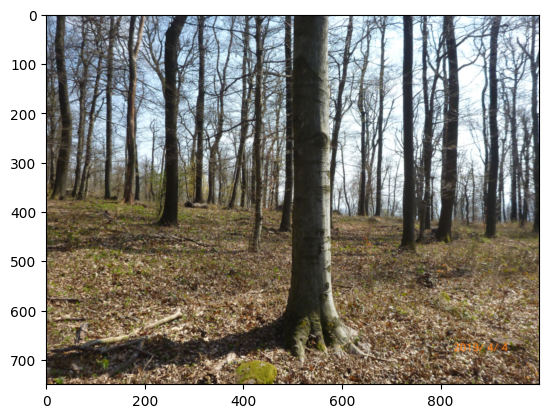

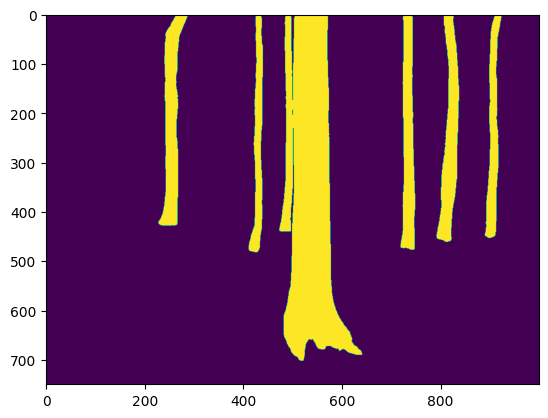

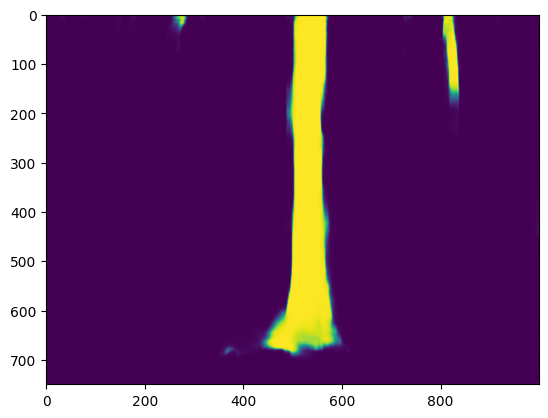

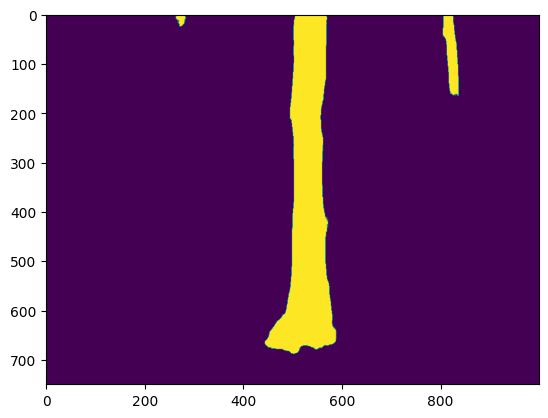

In [18]:
eval(20)

In [ ]:
predictions, results = unet.predict(val_loader, device=device)

In [19]:
torch.save(unet.state_dict(), 'unet_model.pth')

In [ ]:
path = "path"
unet.load_state_dict(torch.load(path, map_location=device))